In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
# import missingno as msno
#from google.colab import data_table
# from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [6]:
final_df = pd.read_csv('./final_data_after_feature_engineering.csv', index_col=0).reset_index(drop=True)
final_df

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,macd top100_to_total_percentage,macd hist avg_fee_to_reward,macd signal avg_fee_to_reward,macd avg_fee_to_reward,macd hist number_of_coins_in_circulation,macd signal number_of_coins_in_circulation,macd number_of_coins_in_circulation,macd hist miner_revenue,macd signal miner_revenue,macd miner_revenue
0,2013-01-02,13.24,13.24,12.77,13.22,39280,114077,31809,2979637,2.280465e+13,...,-0.066491,0.018084,-0.013204,-0.022966,821.434249,24193.356104,23677.264207,959.494422,1.030414e+04,7.216723e+03
1,2013-01-03,13.12,13.19,12.98,13.09,42147,108023,38197,2979637,2.372489e+13,...,-0.066491,0.018084,-0.013204,-0.022966,821.434249,24193.356104,23677.264207,959.494422,1.030414e+04,7.216723e+03
2,2013-01-04,13.09,13.26,12.96,13.19,48436,141811,34990,2979637,2.260818e+13,...,-0.066491,0.018084,-0.013204,-0.022966,821.434249,24193.356104,23677.264207,959.494422,1.030414e+04,7.216723e+03
3,2013-01-05,13.12,13.24,12.84,13.19,39455,118240,38008,2979637,2.259070e+13,...,-0.066491,0.018084,-0.013204,-0.022966,821.434249,24193.356104,23677.264207,959.494422,1.030414e+04,7.216723e+03
4,2013-01-06,13.19,13.19,13.03,13.15,32881,100608,30021,2979637,2.076659e+13,...,-0.066491,0.018084,-0.013204,-0.022966,821.434249,24193.356104,23677.264207,959.494422,1.030414e+04,7.216723e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,2024-01-15,41700.91,43332.79,41682.62,42492.35,408385,754220,375303,73197634206448,4.427672e+20,...,-2.159991,0.404117,-2.031856,-1.627739,-841.598294,4876.503936,4034.905642,-120538.279622,-9.672209e+05,-1.087759e+06
4028,2024-01-16,42483.97,43569.31,42033.30,43131.47,469997,752060,403561,73197634206448,4.766308e+20,...,-1.996092,0.429529,-1.924474,-1.494944,-776.339824,4682.418980,3906.079156,-130536.125435,-9.998549e+05,-1.130391e+06
4029,2024-01-17,43132.80,43185.47,42164.99,42741.63,449294,747345,458901,73197634206448,4.007983e+20,...,-1.844854,0.340037,-1.839465,-1.499428,-706.556989,4505.779733,3799.222744,-207007.244599,-1.051607e+06,-1.258614e+06
4030,2024-01-18,42740.17,42879.39,40605.54,41292.17,483875,739462,474198,73197634206448,4.756212e+20,...,-1.705817,0.274784,-1.770768,-1.495984,-639.336540,4345.945598,3706.609058,-416383.399208,-1.155703e+06,-1.572086e+06


This function is useful for understanding the importance of different features in a dataset and selecting the most significant ones for further analysis. It leverages visualization techniques to make feature importance information more accessible.

In [7]:
def feature_imp(df,feat_importance,n_select_features):
    feat_imp_df = pd.DataFrame(data = {"Feature Name": df.columns,"Feature Importance":feat_importance})

    feat_imp_df = feat_imp_df.sort_values("Feature Importance",ascending=False)[:n_select_features]
    
    # Create a bar plot to visualize the feature importance's
    fig,ax = plt.subplots(figsize=(14,12))
    ax = sns.barplot(x = "Feature Importance",y = "Feature Name",
                    data=feat_imp_df,palette="nipy_spectral")
    plt.title('Feature Importances')

    cmap = plt.get_cmap('nipy_spectral_r',n_select_features)
    minfi = min(feat_imp_df['Feature Importance'])
    maxfi = max(feat_imp_df['Feature Importance'])
    norm = mpl.colors.Normalize(vmin=minfi,vmax=maxfi)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    
    # Show the color bar
    # plt.colorbar(sm,ticks=np.linspace(minfi,maxfi,n_select_features),
    #             boundaries=np.arange(minfi,maxfi+0.001,.0001))
    
    # Display the grid lines along the x-axis
    ax.xaxis.grid()
    # Show the plot
    plt.show()
    # Return the DataFrame with feature importance's and selected features from the original DataFrame
    return feat_imp_df,df[feat_imp_df['Feature Name']]

Data Scaling

In [8]:
X = final_df.drop(['Date','next_day_closing_price'],axis=1)

scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

scaler = MinMaxScaler()
X_scaled[X.columns] =  scaler.fit_transform(X_scaled[X.columns])

X_scaled

,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,mining_profitability,...,macd top100_to_total_percentage,macd hist avg_fee_to_reward,macd signal avg_fee_to_reward,macd avg_fee_to_reward,macd hist number_of_coins_in_circulation,macd signal number_of_coins_in_circulation,macd number_of_coins_in_circulation,macd hist miner_revenue,macd signal miner_revenue,macd miner_revenue
0,2.221601e-06,1.304773e-06,0.000000,1.925380e-06,0.012995,0.041224,0.002200,1.483928e-10,6.350186e-09,0.167238,...,0.214901,0.361619,0.432514,0.382568,0.750917,0.648944,0.632049,0.661004,0.493556,0.493635
1,4.443201e-07,5.798991e-07,0.000003,0.000000e+00,0.017085,0.034658,0.010059,1.483928e-10,7.849089e-09,0.170458,...,0.214901,0.361619,0.432514,0.382568,0.750917,0.648944,0.632049,0.661004,0.493556,0.493635
2,0.000000e+00,1.594722e-06,0.000003,1.481061e-06,0.026056,0.071304,0.006114,1.483928e-10,6.030176e-09,0.169185,...,0.214901,0.361619,0.432514,0.382568,0.750917,0.648944,0.632049,0.661004,0.493556,0.493635
3,4.443201e-07,1.304773e-06,0.000001,1.481061e-06,0.013245,0.045740,0.009827,1.483928e-10,6.001695e-09,0.155329,...,0.214901,0.361619,0.432514,0.382568,0.750917,0.648944,0.632049,0.661004,0.493556,0.493635
4,1.481067e-06,5.798991e-07,0.000004,8.886368e-07,0.003867,0.026616,0.000000,1.483928e-10,3.030550e-09,0.173229,...,0.214901,0.361619,0.432514,0.382568,0.750917,0.648944,0.632049,0.661004,0.493556,0.493635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,6.174245e-01,6.280255e-01,0.628370,6.291439e-01,0.539517,0.735504,0.424816,1.000000e+00,7.211892e-01,0.000002,...,0.214868,0.432703,0.201846,0.244712,0.299410,0.021905,0.012929,0.640888,0.425131,0.426804
4028,6.290222e-01,6.314544e-01,0.633658,6.386096e-01,0.627406,0.733161,0.459583,1.000000e+00,7.763468e-01,0.000002,...,0.214870,0.437382,0.214116,0.256120,0.317127,0.015605,0.008869,0.639233,0.422847,0.424202
4029,6.386318e-01,6.258897e-01,0.635644,6.328359e-01,0.597873,0.728048,0.527670,1.000000e+00,6.528292e-01,0.000003,...,0.214873,0.420903,0.223830,0.255735,0.336073,0.009871,0.005500,0.626572,0.419224,0.416376
4030,6.328167e-01,6.214523e-01,0.612128,6.113685e-01,0.647202,0.719498,0.546490,1.000000e+00,7.747025e-01,0.000003,...,0.214875,0.408887,0.231680,0.256030,0.354323,0.004682,0.002581,0.591906,0.411938,0.397244


In [9]:
y = final_df['next_day_closing_price']
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,bootstrap=True,
                           verbose=5,random_state=1)
rf.fit(X_scaled,y)
     

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100building tree 24 of 100

building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   25.2s


building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed:   48.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.5s finished


RandomForestRegressor(n_jobs=-1, random_state=1, verbose=5)

In [10]:
feat_range = list(range(10,60,5))

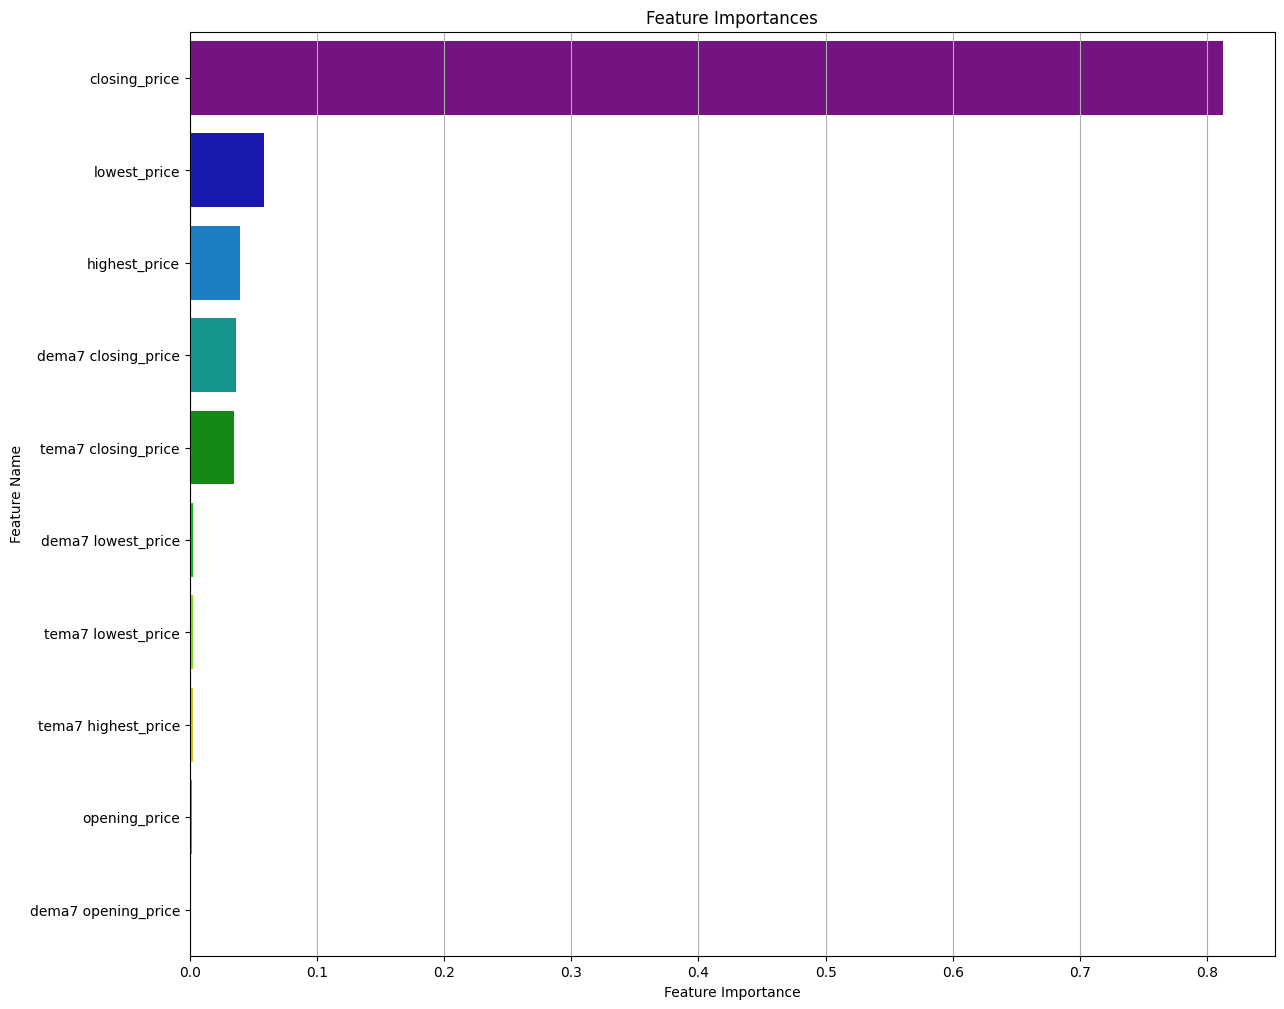

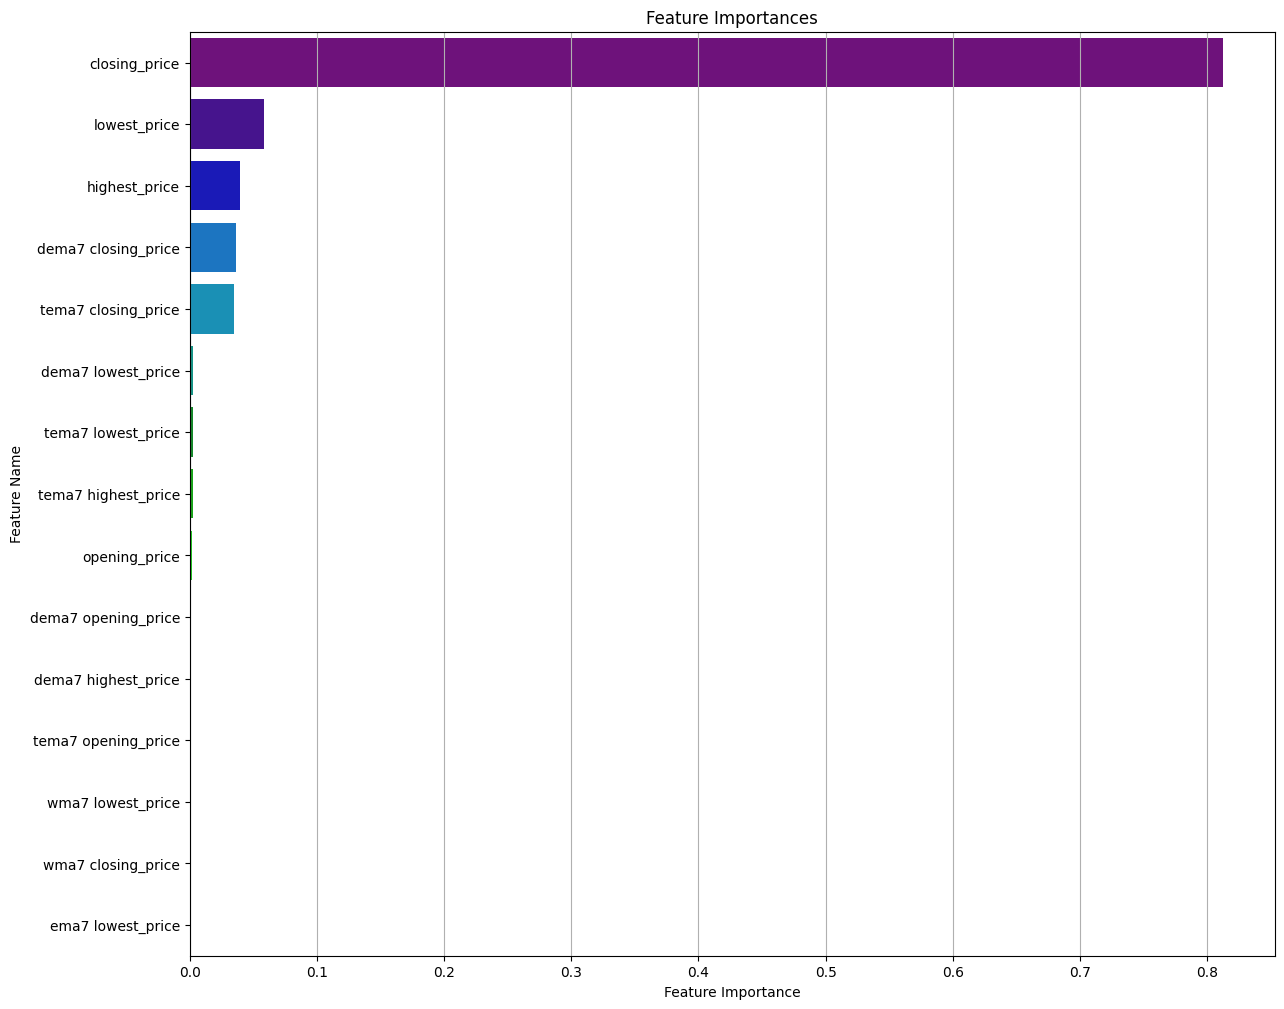

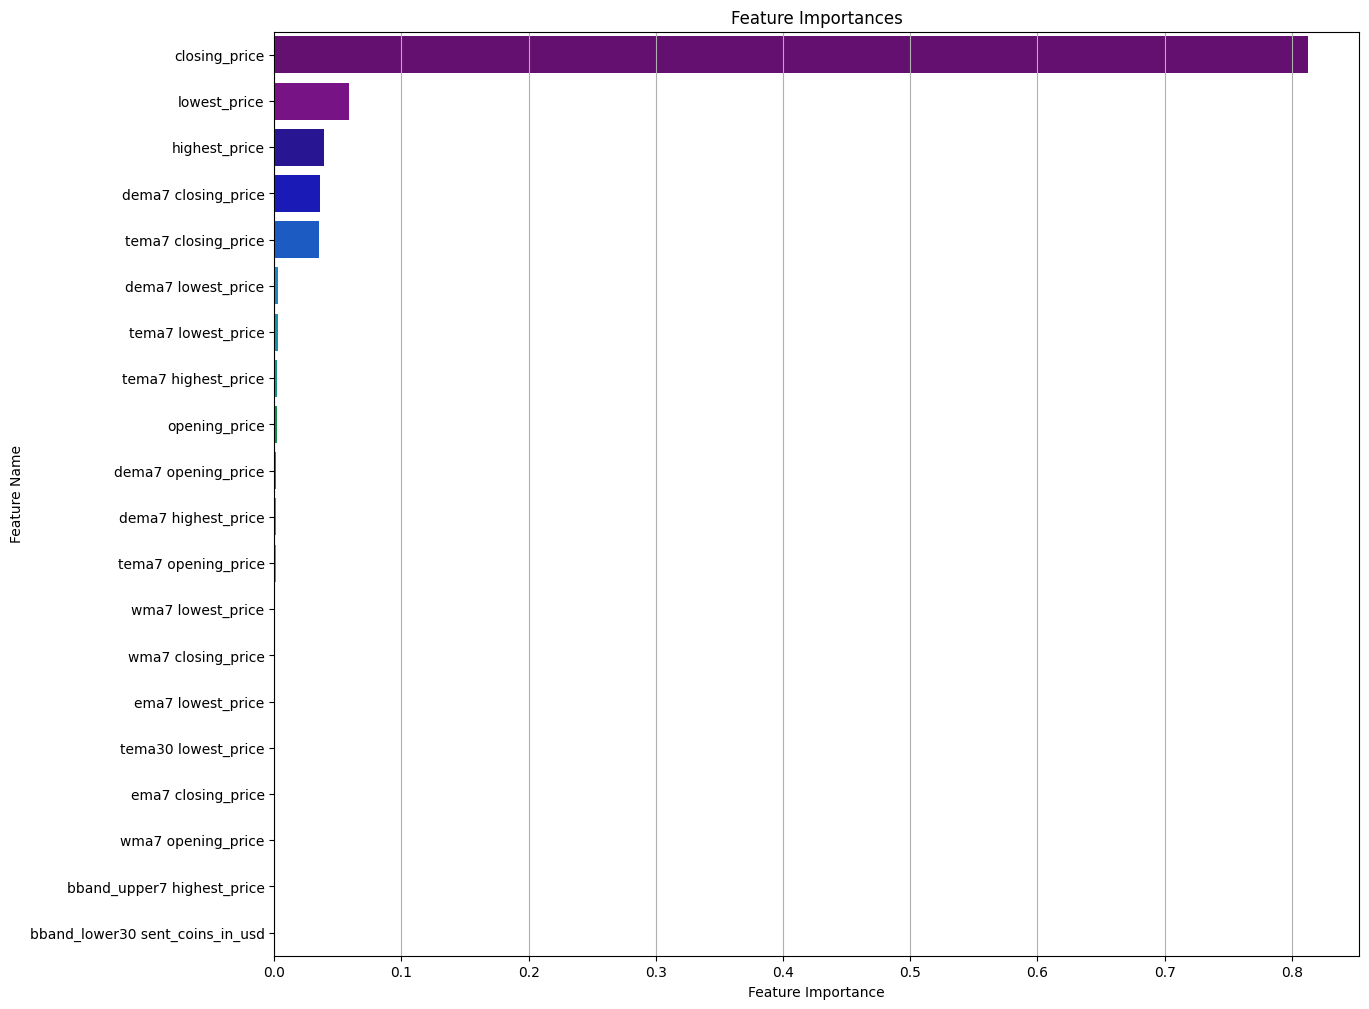

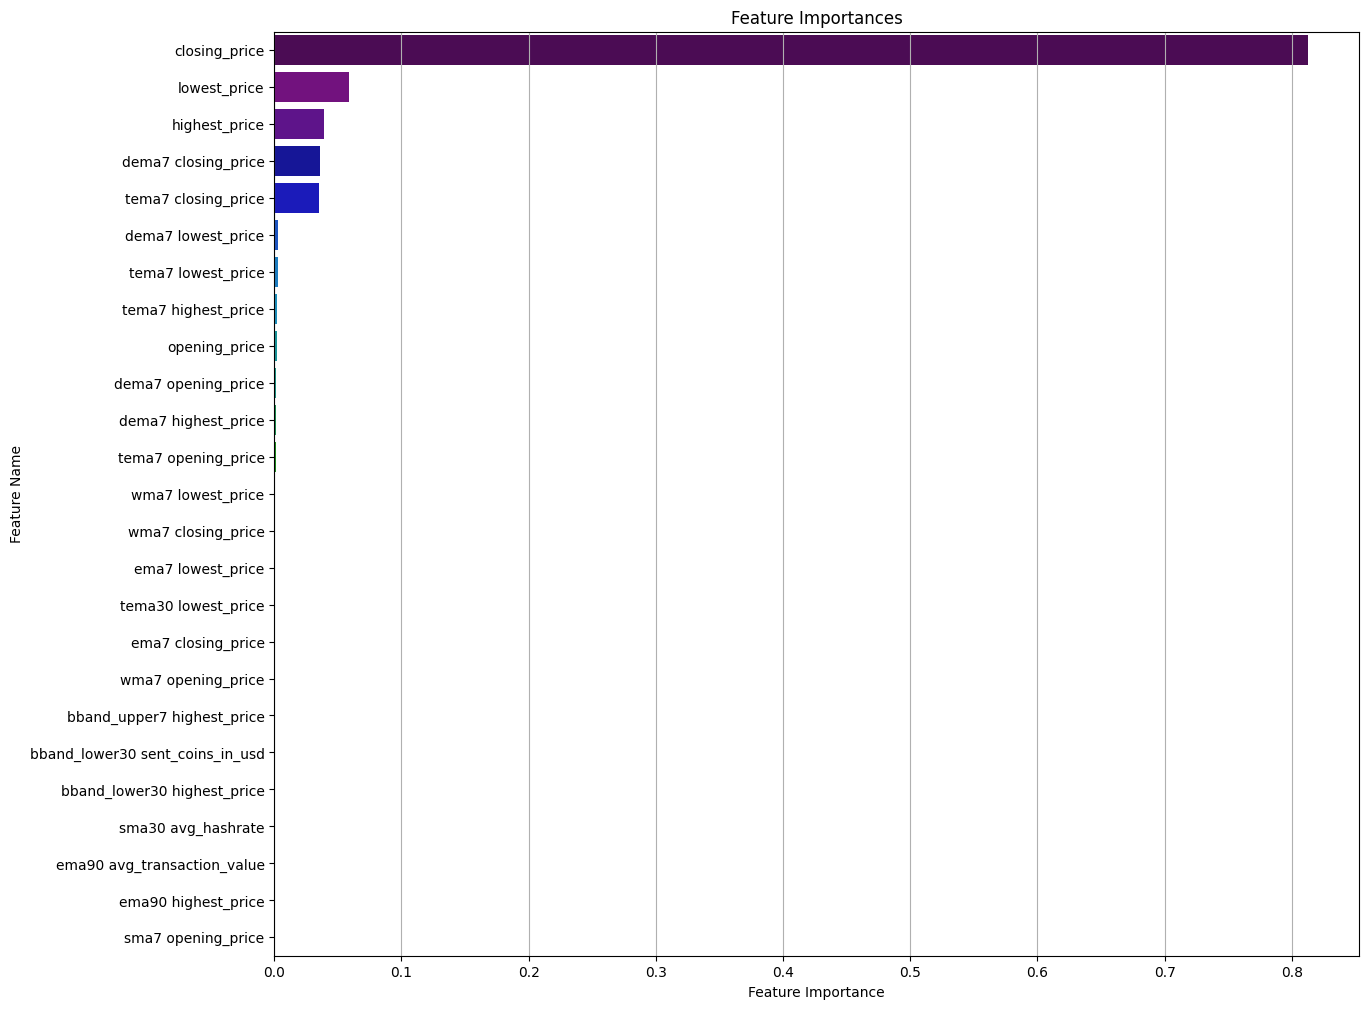

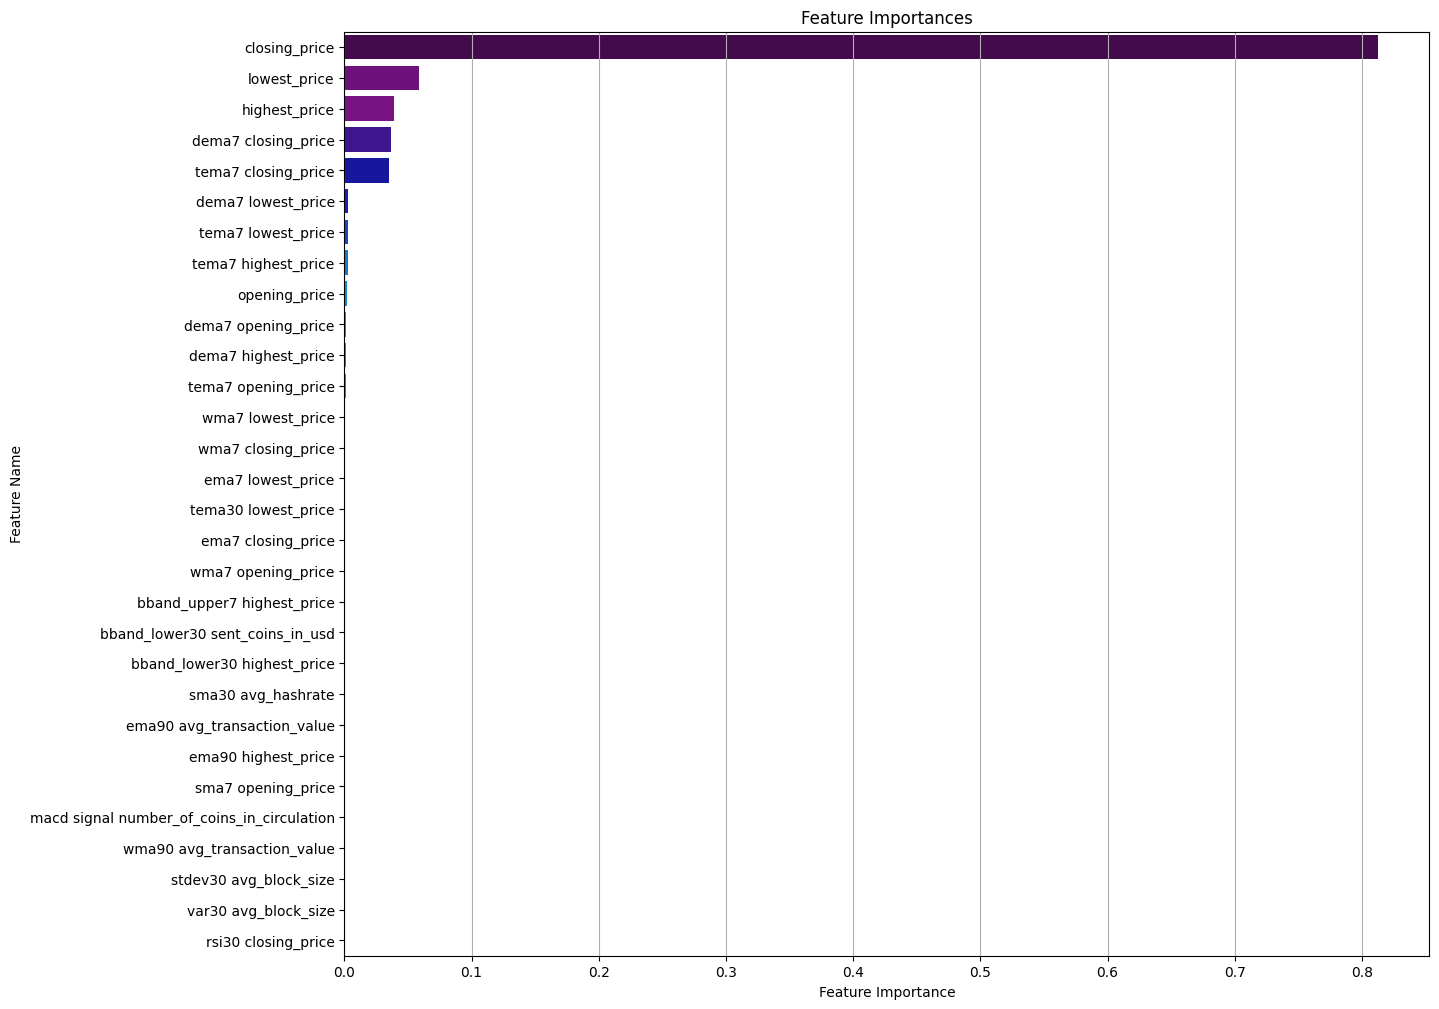

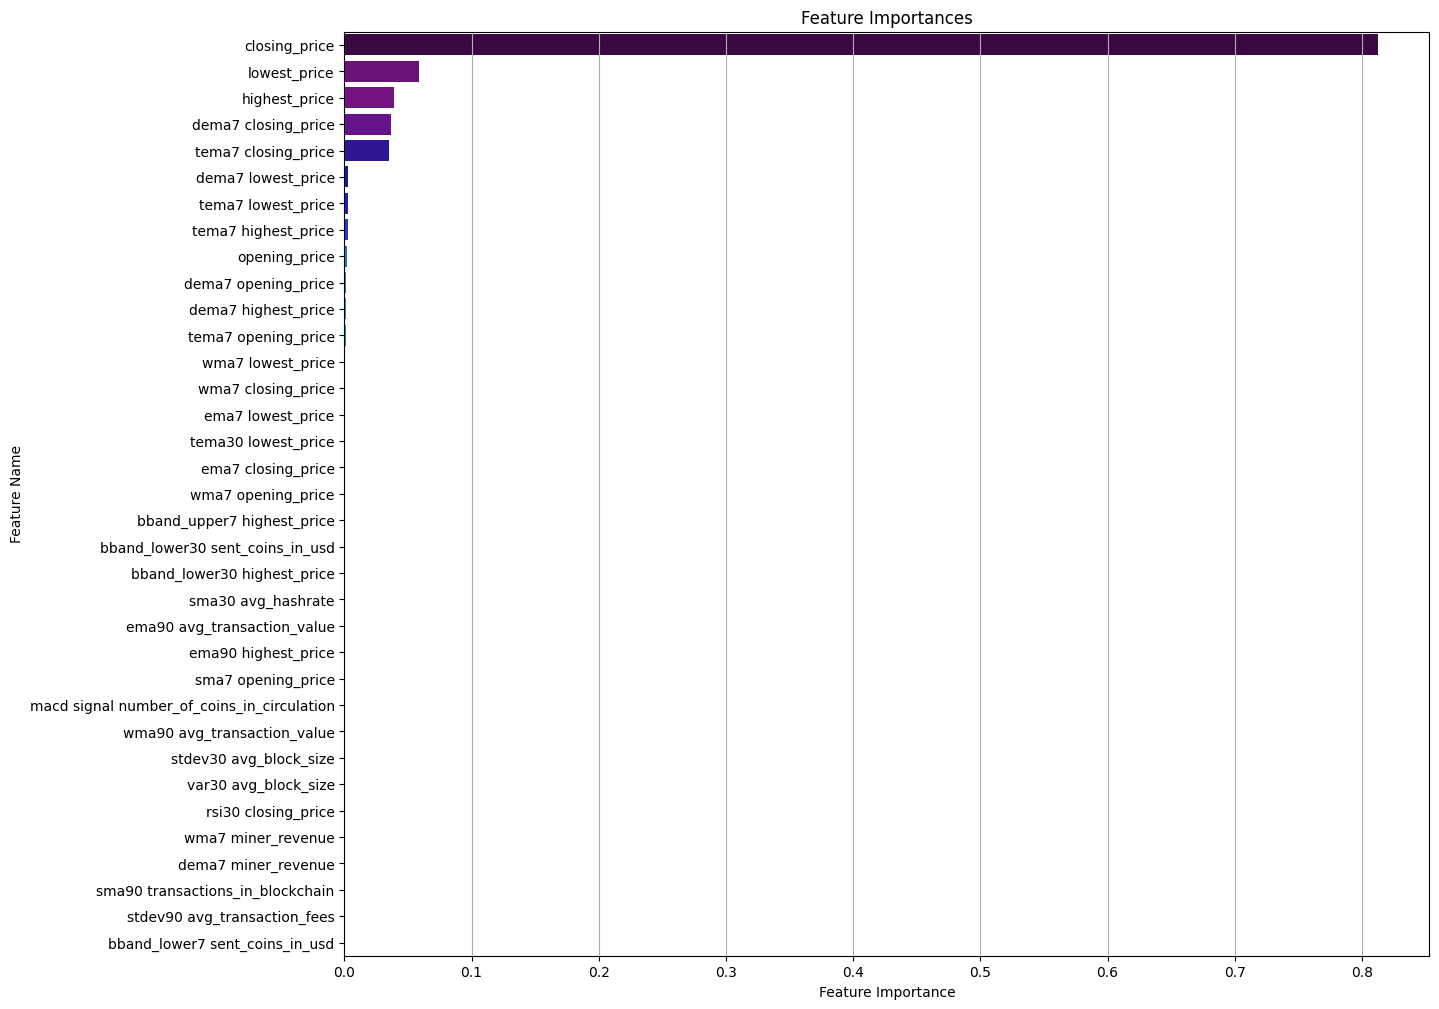

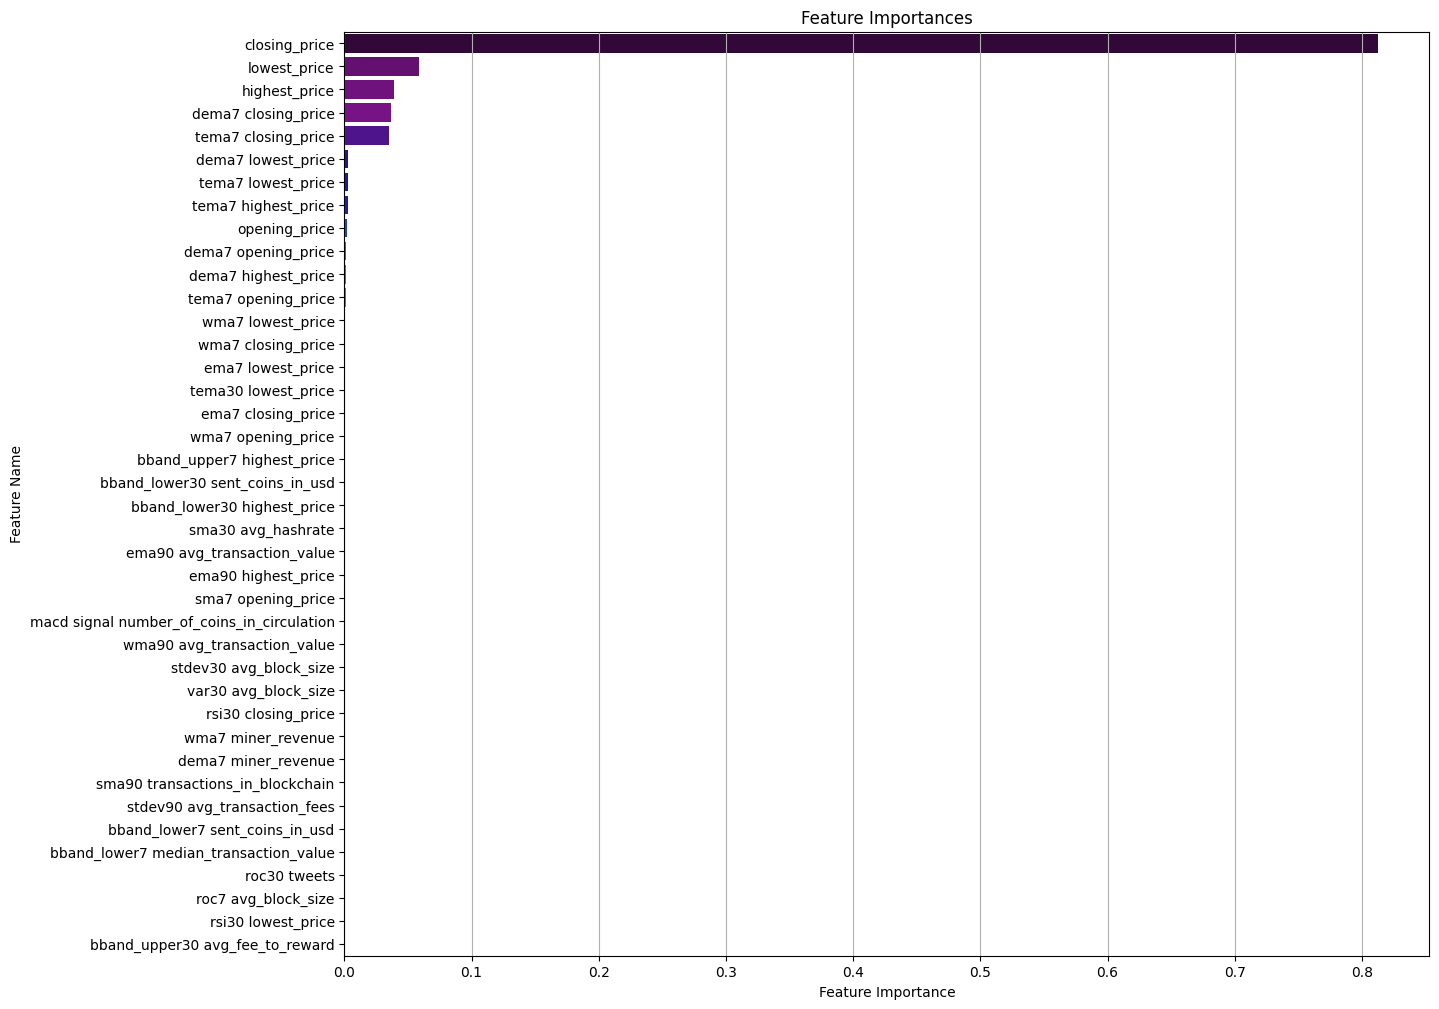

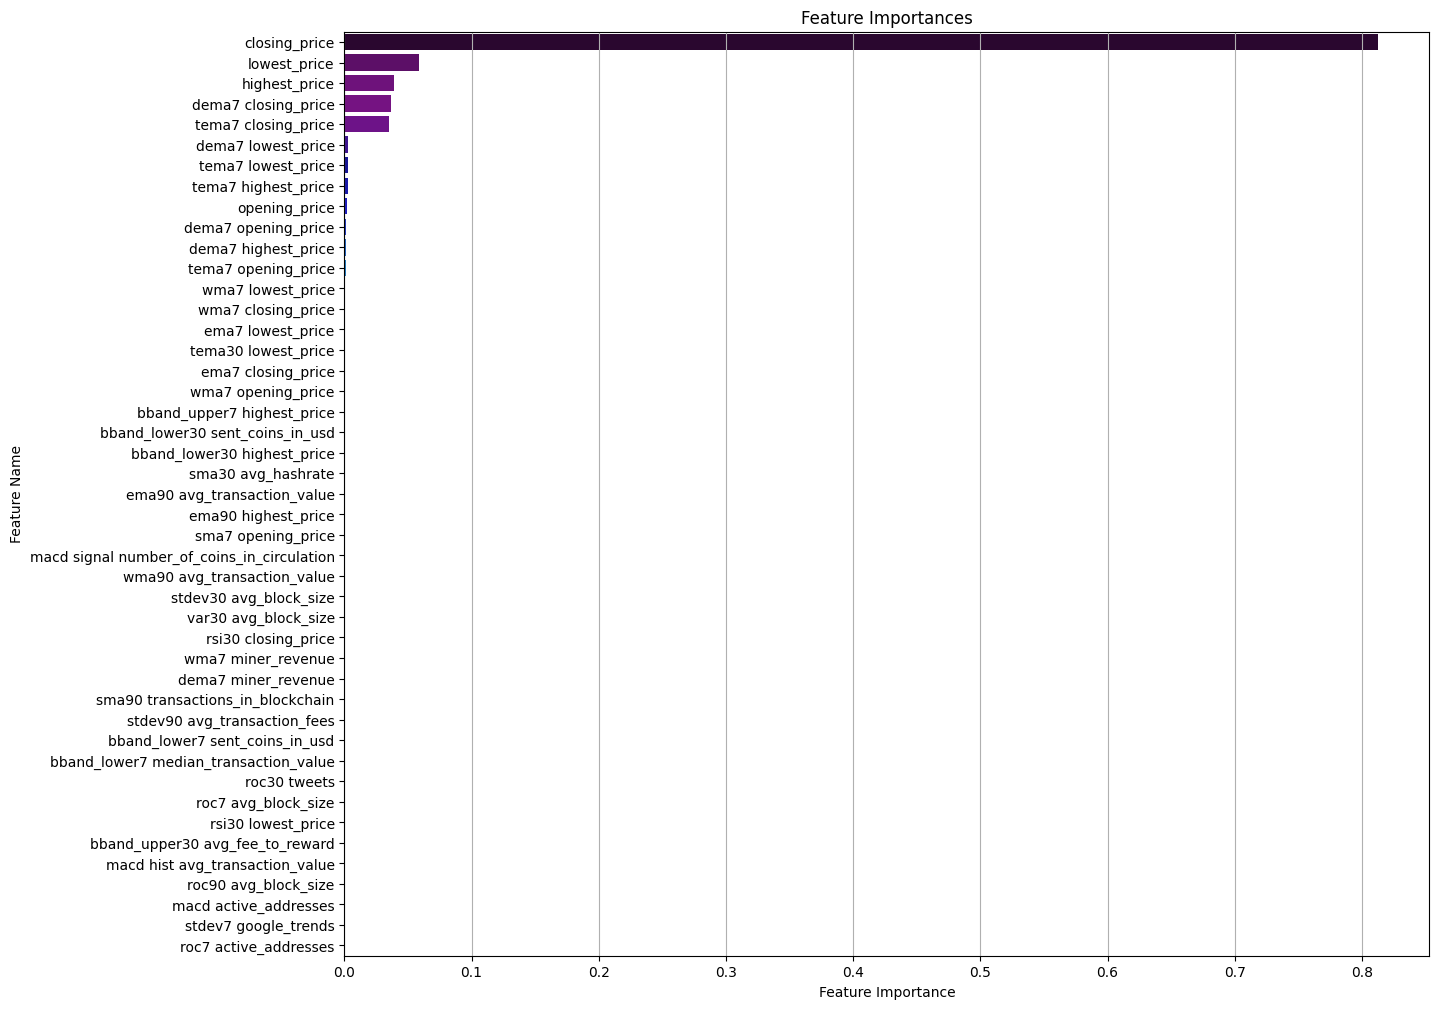

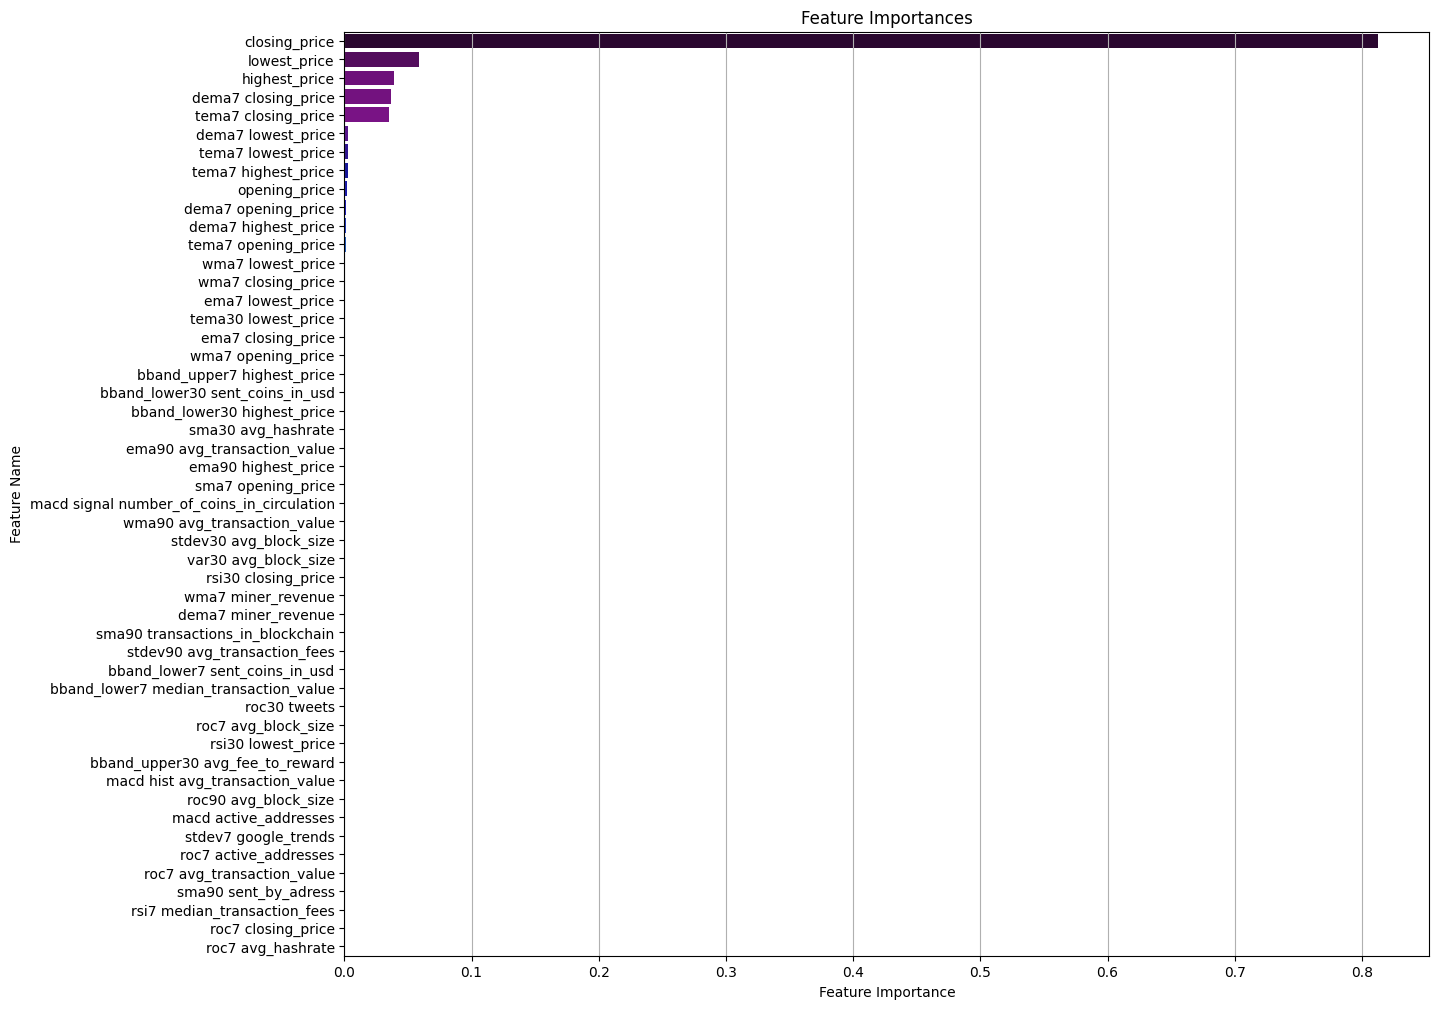

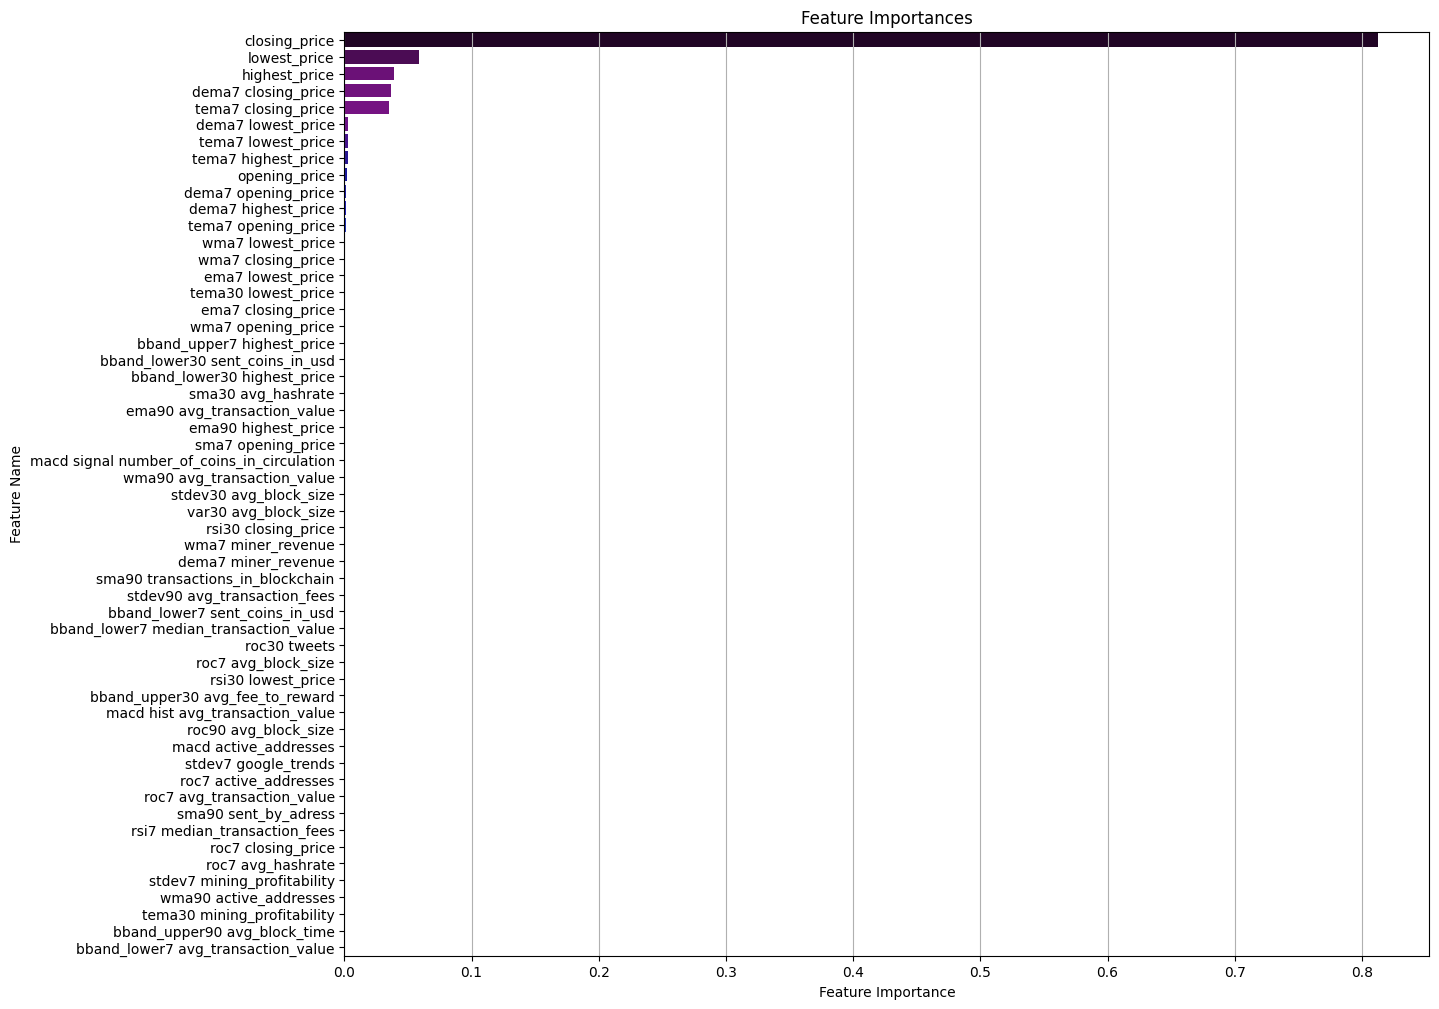

In [11]:
for i in feat_range:
    feat_imp_df,final_df_next_day = feature_imp(X_scaled,rf.feature_importances_,i)
    final_df_next_day.insert(loc=0, column='Date', value=final_df['Date'])
    final_df_next_day['next_day_closing_price'] = final_df['next_day_closing_price']
    feat_imp_df.to_csv(f'./feature_imp_{i}.csv',index=False)
    final_df_next_day.to_csv(f'./final_df_next_day_{i}.csv',index=False)
     